# alternating blocked descent

- using SGD on $C$
- after each pass over the observed parts of the covariance matrix, use analyic solution for $A$, $\Pi$

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import glob, os

os.chdir('../core')
import SSID_Hankel_loss 
from utility import get_subpop_stats, draw_sys, gen_data
from SSID_Hankel_loss import run_bad, plot_outputs_l2_gradient_test, l2_bad_sis_setup
os.chdir('../dev')

import psutil
import time

# load ancient code for drawing from LDS ...
os.chdir('../../../../pyRRHDLDS/core')
import ssm_scripts
import ssm_fit
os.chdir('../../code_le_stitch/iterSSID/python/dev')

#np.random.seed(0)

p,n,nr = 10000, 100, 50
k,l = 3,3

T = np.inf
mmap = True
chunksize = np.min((p//2,5000))
max_i = p//chunksize
max_zip_size = p

eig_m_r, eig_M_r, eig_m_c, eig_M_c = 0.8, 0.99, 0.8, 0.99

batch_size = p # batch_size = 1 (size-1 mini-batches), p (column mini-batches), None (full gradients)
lag_range  = 1
a, b1, b2, e = 0.001, 0.9, 0.99, 1e-8
max_iter_nl  = 10
max_iter_lin = 0
reps = 1

verbose=True

# create subpopulations
sub_pops = (np.arange(0,p), np.arange(0,p))
#sub_pops = (np.arange(p//2), np.arange(p//2,p))

"""
len_sub_pops = 9                                            #
pop_size = p//5                                             # stochastic turn-over ('funky' observation scheme)
sub_pops = [np.arange(pop_size)]                            # 
for i in range(1,len_sub_pops):
    old = np.atleast_1d(np.random.choice(sub_pops[i-1],pop_size//2,replace=False))
    assert old.size == pop_size//2
    assert np.all([old[j] in sub_pops[i-1] for j in range(old.size)])
    new = np.arange((1/2+i/2)*pop_size,((i+1)/2+1/2)*pop_size,dtype=np.int)
    sub_pops.append(np.hstack((old,new)))
    assert len(sub_pops[-1]) == pop_size
"""
#sub_pops = (np.arange(0,200), np.arange(100,300), np.arange(200,400), np.arange(300,p))
#sub_pops = (np.arange(0,2*p//10), np.arange(p//10,3*p//10), np.arange(2*p//10,4*p//10), np.arange(3*p//10,5*p//10),
#            np.arange(4*p//10,6*p//10), np.arange(5*p//10,7*p//10), np.arange(6*p//10,8*p//10), 
#            np.arange(7*p//10,9*p//10), np.arange(8*p//10,p))
#sub_pops = (np.arange(0,p//2+1), np.arange(p//2-1,p))
#sub_pops = (np.arange(10,p), np.arange(0,p-10))

obs_idx, idx_grp, co_obs, _, _, _, Om, _, _ = \
    get_subpop_stats(sub_pops=sub_pops, p=p, verbose=False)

# draw system matrices    
ev_r = np.linspace(eig_m_r, eig_M_r, nr)
ev_c = np.exp(2 * 1j * np.pi * np.random.uniform(size= (n - nr)//2))
ev_c = np.linspace(eig_m_c, eig_M_c, (n - nr)//2) * ev_c

calc_stats = True if T == np.inf else False
pars_true, Qs, Qs_full = draw_sys(p=p,n=n,k=k,l=l, nr=nr, ev_r=ev_r,ev_c=ev_c,calc_stats=calc_stats,
                                 return_masked=False, mmap=mmap, chunksize = chunksize)
pars_true['d'], pars_true['mu0'], pars_true['V0'] = np.zeros(p), np.zeros(n), pars_true['Pi'].copy()

#pars_true['R'] = 10e-5 * np.ones(p)
#pars_true['Q'] = 10e-10 * np.eye(n)

if calc_stats:
    x,y = np.zeros((n,0)), np.zeros((p,0))
else:
    print('computing empirical covariances')
    x,y = gen_data(pars=pars_true, T = T ) 
    for m in range(k+l):
        print('computing time-lagged covariance for lag ', str(m))
        if mmap:
            Q = np.memmap('../fits/Qs_'+str(m), dtype=np.float, mode='w+', shape=(p,p))
        for i in range(max_i):
            idx_i  = range(i*chunksize, (i+1)*chunksize)
            for j in range(max_i):
                idx_j = range(j*chunksize, (j+1)*chunksize)
                Q[np.ix_(idx_i,idx_j)] = np.cov(y[idx_i,m:m-(k+l)], y[idx_j,:-(k+l)])[:chunksize,chunksize:]     
        if mmap:
            del Q
            Qs_full[m] = np.memmap('../fits/Qs_'+str(m), dtype=np.float, mode='r', shape=(p,p))
        Qs[m] = Qs_full[m]
        
        
print('\n')
print(psutil.virtual_memory())
print(psutil.swap_memory())

#Qs[0] = None     
#Qs_full[0] = None

    

computing time-lagged covariance for lag m = 0
computing time-lagged covariance for lag m = 1
computing time-lagged covariance for lag m = 2
computing time-lagged covariance for lag m = 3
computing time-lagged covariance for lag m = 4
computing time-lagged covariance for lag m = 5


svmem(total=67504091136, available=65053278208, percent=3.6, used=9099210752, free=58404880384, active=2796527616, inactive=5323120640, buffers=541085696, cached=6107312128)
sswap(total=68659703808, used=0, free=68659703808, percent=0.0, sin=0, sout=0)


In [ ]:
for rep in range(reps):        
    
    t = time.time()
    
    linearity = 'False'
    stable = False
    sym_psd = False
    pars_init, pars_est, traces = run_bad(k=k,l=l,n=n,Qs=Qs,Om=Om,Qs_full=Qs_full,
                                          sub_pops=sub_pops,idx_grp=idx_grp,co_obs=co_obs,obs_idx=obs_idx,
                                          linearity=linearity,stable=stable,init='default',
                                          alpha=a,b1=b1,b2=b2,e=e,max_iter=max_iter_nl,batch_size=batch_size,
                                          verbose=verbose, sym_psd=sym_psd, lag_range = lag_range, max_zip_size=max_zip_size)
    #f_i = l2_sis_setup(k,l,n,Qs,Om,idx_grp,obs_idx)[0] # get f to compute final errors
    #plot_outputs_l2_gradient_test(pars_true, pars_init, pars_est, k, l, Qs, 
    #                                   Qs_full, Om, Ovc, Ovw, f_i, None, traces = traces,
    #                                   linearity=linearity, idx_grp = idx_grp, co_obs = co_obs, 
    #                                   if_flip = True, m = 1)

    
    print('fitting time was ', time.time() - t)

print('\n')
print(psutil.virtual_memory())
print(psutil.swap_memory())

f_i = l2_bad_sis_setup(k,l,n,Qs,Om,idx_grp,obs_idx,Qs_full,linearity, stable, sym_psd, 
                            verbose=False, batch_size=batch_size, W=None)[0]
plot_outputs_l2_gradient_test(pars_true, pars_init, pars_est, k, l, Qs, 
                                   Qs_full, Om, Om, Om, f_i, None, traces = traces,
                                   linearity=linearity, idx_grp = idx_grp, co_obs = co_obs, 
                                   if_flip = True, m = 0)

pars = pars_est
idx1 = np.arange(p) #np.random.choice(p, np.min((p,1000)), replace=False)
idx2 = np.arange(p) #np.random.choice(p, np.min((p,1000)), replace=False)
for m in range(1,k+l-1):
    Qrec = pars['C'][idx1,:].dot(pars['X'][:,m].reshape(n,n)).dot(pars['C'][idx2,:].T) 
    Qrec = Qrec + np.diag(pars['R'])[np.ix_(idx1,idx2)] if m==0 else Qrec
    print('m',m,', corr', 
    np.corrcoef( Qrec.reshape(-1), (Qs[m][np.ix_(idx1,idx2)]).reshape(-1) )[0,1],', MSE', 
        np.mean( (Qrec - Qs[m][np.ix_(idx1,idx2)])**2 ) )

starting descent
lag_range 1
starting extraction of A
extracting latent cov. matrix for time-lag m= 1
extracting latent cov. matrix for time-lag m= 2
extracting latent cov. matrix for time-lag m= 3
extracting latent cov. matrix for time-lag m= 4
extracting latent cov. matrix for time-lag m= 5
using size-p mini-batches (coviarance columms)
....................................................................................................  [   100/10000,    0.03sec avg, ETA 05:46 ]
....................................................................................................  [   200/10000,    0.03sec avg, ETA 05:41 ]
....................................................................................................  [   300/10000,    0.03sec avg, ETA 05:39 ]
....................................................................................................  [   400/10000,    0.03sec avg, ETA 05:34 ]
...............................................................................

In [ ]:
t = time.time()
X = SSID_Hankel_loss.s_X_l2_Hankel_fully_obs(pars_true['C'], pars_true['R'], 
                                                    Qs, k, l, idx_grp, co_obs, 
                                                    max_i, chunksize)
print('took ', time.time() - t)

In [ ]:
t = time.time()
X = SSID_Hankel_loss.s_X_l2_Hankel_vec(pars_true['C'], pars_true['R'], 
                                                    Qs, k, l, idx_grp, co_obs)
print('took ', time.time() - t)


# just one more turn...

In [ ]:
max_iter_nl = 20000
batch_size = None # batch_size = 1 (size-1 mini-batches), p (column mini-batches), None (full gradients)
lag_range  = None
a = 0.000001

t = time.time()

pars_init, pars_est, traces = run_bad(k=k,l=l,n=n,Qs=Qs,Om=Om,Qs_full=Qs_full,
                                      sub_pops=sub_pops,idx_grp=idx_grp,co_obs=co_obs,obs_idx=obs_idx,
                                      linearity=linearity,stable=stable,init=pars_est,
                                      alpha=a,b1=b1,b2=b2,e=e,max_iter=max_iter_nl,batch_size=batch_size,
                                      verbose=verbose, sym_psd=sym_psd, lag_range = lag_range, max_zip_size=max_zip_size)


print('fitting time was ', time.time() - t)

print('\n')
print(psutil.virtual_memory())
print(psutil.swap_memory())

f_i = l2_bad_sis_setup(k,l,n,Qs,Om,idx_grp,obs_idx,Qs_full,linearity, stable, sym_psd, 
                            verbose=False, batch_size=batch_size, W=None)[0]
plot_outputs_l2_gradient_test(pars_true, pars_init, pars_est, k, l, Qs, 
                                   Qs_full, Om, Om, Om, f_i, None, traces = traces,
                                   linearity=linearity, idx_grp = idx_grp, co_obs = co_obs, 
                                   if_flip = True, m = 0)
pars = pars_est
idx1 = np.arange(p) #np.random.choice(p, np.min((p,1000)), replace=False)
idx2 = np.arange(p) #np.random.choice(p, np.min((p,1000)), replace=False)
for m in range(1,k+l-1):
    Qrec = pars['C'][idx1,:].dot(pars['X'][:,m].reshape(n,n)).dot(pars['C'][idx2,:].T) 
    Qrec = Qrec + np.diag(pars['R'])[np.ix_(idx1,idx2)] if m==0 else Qrec
    print('m',m,', corr', 
    np.corrcoef( Qrec.reshape(-1), (Qs[m][np.ix_(idx1,idx2)]).reshape(-1) )[0,1],', MSE', 
        np.mean( (Qrec - Qs[m][np.ix_(idx1,idx2)])**2 ) )


In [ ]:
max_iter_nl = 200000
batch_size = None # batch_size = 1 (size-1 mini-batches), p (column mini-batches), None (full gradients)
lag_range  = None
a = 0.0000001

t = time.time()

pars_init, pars_est, traces = run_bad(k=k,l=l,n=n,Qs=Qs,Om=Om,Qs_full=Qs_full,
                                      sub_pops=sub_pops,idx_grp=idx_grp,co_obs=co_obs,obs_idx=obs_idx,
                                      linearity=linearity,stable=stable,init=pars_est,
                                      alpha=a,b1=b1,b2=b2,e=e,max_iter=max_iter_nl,batch_size=batch_size,
                                      verbose=verbose, sym_psd=sym_psd, lag_range = lag_range, max_zip_size=max_zip_size)


print('fitting time was ', time.time() - t)

print('\n')
print(psutil.virtual_memory())
print(psutil.swap_memory())

f_i = l2_bad_sis_setup(k,l,n,Qs,Om,idx_grp,obs_idx,Qs_full,linearity, stable, sym_psd, 
                            verbose=False, batch_size=batch_size, W=None)[0]
plot_outputs_l2_gradient_test(pars_true, pars_init, pars_est, k, l, Qs, 
                                   Qs_full, Om, Om, Om, f_i, None, traces = traces,
                                   linearity=linearity, idx_grp = idx_grp, co_obs = co_obs, 
                                   if_flip = True, m = 0)
pars = pars_est
idx1 = np.arange(p) #np.random.choice(p, np.min((p,1000)), replace=False)
idx2 = np.arange(p) #np.random.choice(p, np.min((p,1000)), replace=False)
for m in range(1,k+l-1):
    Qrec = pars['C'][idx1,:].dot(pars['X'][:,m].reshape(n,n)).dot(pars['C'][idx2,:].T) 
    Qrec = Qrec + np.diag(pars['R'])[np.ix_(idx1,idx2)] if m==0 else Qrec
    print('m',m,', corr', 
    np.corrcoef( Qrec.reshape(-1), (Qs[m][np.ix_(idx1,idx2)]).reshape(-1) )[0,1],', MSE', 
        np.mean( (Qrec - Qs[m][np.ix_(idx1,idx2)])**2 ) )


In [ ]:
max_iter_nl = 200000
batch_size = None # batch_size = 1 (size-1 mini-batches), p (column mini-batches), None (full gradients)
lag_range  = None
a = 0.0000001

t = time.time()

pars_init, pars_est, traces = run_bad(k=k,l=l,n=n,Qs=Qs,Om=Om,Qs_full=Qs_full,
                                      sub_pops=sub_pops,idx_grp=idx_grp,co_obs=co_obs,obs_idx=obs_idx,
                                      linearity=linearity,stable=stable,init=pars_est,
                                      alpha=a,b1=b1,b2=b2,e=e,max_iter=max_iter_nl,batch_size=batch_size,
                                      verbose=verbose, sym_psd=sym_psd, lag_range = lag_range, max_zip_size=max_zip_size)


print('fitting time was ', time.time() - t)

print('\n')
print(psutil.virtual_memory())
print(psutil.swap_memory())

f_i = l2_bad_sis_setup(k,l,n,Qs,Om,idx_grp,obs_idx,Qs_full,linearity, stable, sym_psd, 
                            verbose=False, batch_size=batch_size, W=None)[0]
plot_outputs_l2_gradient_test(pars_true, pars_init, pars_est, k, l, Qs, 
                                   Qs_full, Om, Om, Om, f_i, None, traces = traces,
                                   linearity=linearity, idx_grp = idx_grp, co_obs = co_obs, 
                                   if_flip = True, m = 0)
pars = pars_est
idx1 = np.arange(p) #np.random.choice(p, np.min((p,1000)), replace=False)
idx2 = np.arange(p) #np.random.choice(p, np.min((p,1000)), replace=False)
for m in range(1,k+l-1):
    Qrec = pars['C'][idx1,:].dot(pars['X'][:,m].reshape(n,n)).dot(pars['C'][idx2,:].T) 
    Qrec = Qrec + np.diag(pars['R'])[np.ix_(idx1,idx2)] if m==0 else Qrec
    print('m',m,', corr', 
    np.corrcoef( Qrec.reshape(-1), (Qs[m][np.ix_(idx1,idx2)]).reshape(-1) )[0,1],', MSE', 
        np.mean( (Qrec - Qs[m][np.ix_(idx1,idx2)])**2 ) )


In [ ]:
Qs[0] = None
Qs_full[0] = None

max_iter_nl = 1000
batch_size = p # batch_size = 1 (size-1 mini-batches), p (column mini-batches), None (full gradients)
lag_range  = None
a = 0.001

t = time.time()

pars_init, pars_est, traces = run_bad(k=k,l=l,n=n,Qs=Qs,Om=Om,Qs_full=Qs_full,
                                      sub_pops=sub_pops,idx_grp=idx_grp,co_obs=co_obs,obs_idx=obs_idx,
                                      linearity=linearity,stable=stable,init=pars_est,
                                      alpha=a,b1=b1,b2=b2,e=e,max_iter=max_iter_nl,batch_size=batch_size,
                                      verbose=verbose, sym_psd=sym_psd, lag_range = lag_range, max_zip_size=max_zip_size)


print('fitting time was ', time.time() - t)

print('\n')
print(psutil.virtual_memory())
print(psutil.swap_memory())

f_i = l2_bad_sis_setup(k,l,n,Qs,Om,idx_grp,obs_idx,Qs_full,linearity, stable, sym_psd, 
                            verbose=False, batch_size=batch_size, W=None)[0]
plot_outputs_l2_gradient_test(pars_true, pars_init, pars_est, k, l, Qs, 
                                   Qs_full, Om, Om, Om, f_i, None, traces = traces,
                                   linearity=linearity, idx_grp = idx_grp, co_obs = co_obs, 
                                   if_flip = True, m = 0)
pars = pars_est
idx1 = np.arange(p) #np.random.choice(p, np.min((p,1000)), replace=False)
idx2 = np.arange(p) #np.random.choice(p, np.min((p,1000)), replace=False)
for m in range(1,k+l-1):
    Qrec = pars['C'][idx1,:].dot(pars['X'][:,m].reshape(n,n)).dot(pars['C'][idx2,:].T) 
    Qrec = Qrec + np.diag(pars['R'])[np.ix_(idx1,idx2)] if m==0 else Qrec
    print('m',m,', corr', 
    np.corrcoef( Qrec.reshape(-1), (Qs[m][np.ix_(idx1,idx2)]).reshape(-1) )[0,1],', MSE', 
        np.mean( (Qrec - Qs[m][np.ix_(idx1,idx2)])**2 ) )


In [ ]:
m = 5
pars = pars_est
idx1 = np.arange(0, p//2)
idx2 = np.arange(p//2, p)

Qrec = pars['C'][idx1,:].dot(pars['X'][:,m].reshape(n,n)).dot(pars['C'][idx2,:].T) 
Qrec = Qrec + np.diag(pars['R'])[np.ix_(idx1,idx2)] if m==0 else Qrec
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(Qs_full[m][np.ix_(idx1,idx2)], interpolation='none')
plt.subplot(1,3,2)
plt.imshow(Qrec, interpolation='none')
plt.subplot(1,3,3)
plt.plot(Qrec.reshape(-1,), Qs[m][np.ix_(idx1,idx2)].reshape(-1,), '.')

print('corr', np.corrcoef(Qrec.reshape(-1,), Qs[m][np.ix_(idx1,idx2)].reshape(-1,))[0,1])
plt.show()

# Oops... (recovering broken run)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.optimize import fmin_bfgs, check_grad
import glob, os

os.chdir('../core')
import SSID_Hankel_loss 
from utility import get_subpop_stats, draw_sys, gen_data
from SSID_Hankel_loss import run_bad, plot_outputs_l2_gradient_test, l2_bad_sis_setup
os.chdir('../dev')

import psutil
import time

# load ancient code for drawing from LDS ...
os.chdir('../../../../pyRRHDLDS/core')
import ssm_scripts
import ssm_fit
os.chdir('../../code_le_stitch/iterSSID/python/dev')


from scipy.io import savemat # store results for comparison with Matlab code   

os.chdir('../fits/')

save_file = np.load('test_global_opt__Tinf_p100n10r2.npz')
p,n,T,k,l = save_file['p'], save_file['n'], save_file['T'], save_file['k'], save_file['l']
pars_true, batch_size = save_file['pars_true'], save_file['batch_size']
pars_est, pars_init = save_file['pars_est'], save_file['pars_init']

del save_file

Qs_full, Qs = [], []
for m in range(k+l):
    print('loading time-lagged covariance for lag ', str(m))
    Qs_full.append(np.memmap('Qs_'+str(m), dtype=np.float, mode='r', shape=(p,p)))
    Qs.append(Qs_full[m])


sub_pops = (np.arange(p//2), np.arange(p//2,p))
obs_idx, idx_grp, co_obs, _, _, _, Om, _, _ = \
    get_subpop_stats(sub_pops=sub_pops, p=p, verbose=False)
chunksize = 5000
max_i = p//chunksize
max_zip_size = 5000

batch_size = p # batch_size = 1 (size-1 mini-batches), p (column mini-batches), None (full gradients)

a, b1, b2, e = 0.001, 0.9, 0.99, 1e-8
max_iter_nl  = 1
max_iter_lin = 0
reps = 1    

verbose=True
    
        
print('\n')
print(psutil.virtual_memory())
print(psutil.swap_memory())


# analyse results

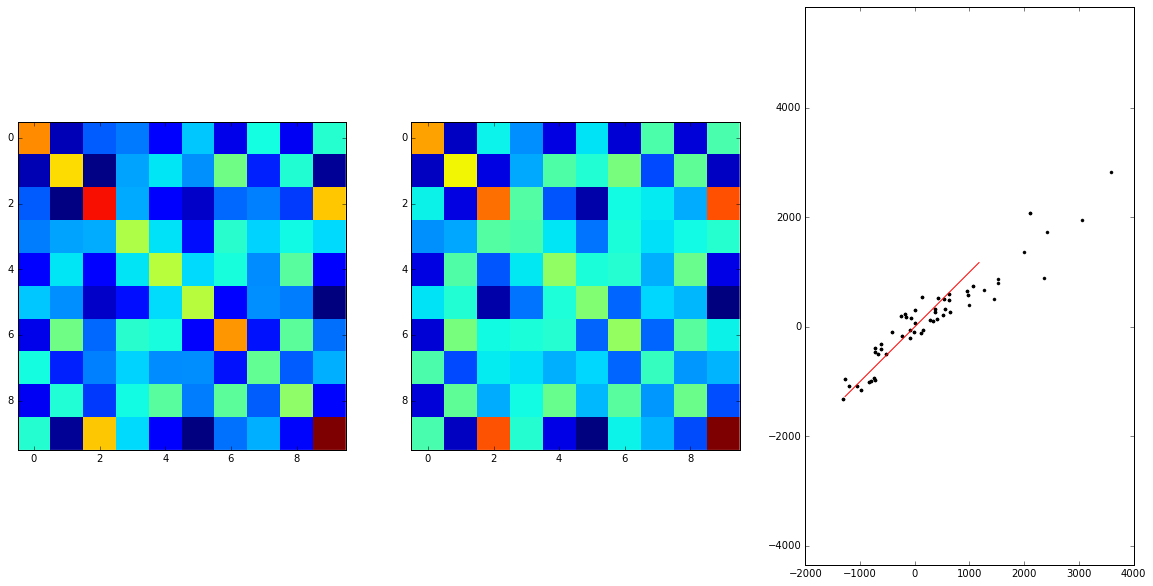

In [15]:
_,X,_ = SSID_Hankel_loss.s_A_l2_Hankel_bad_sis(pars_true['C'],pars_true['R'],k,l,Qs_full,idx_grp,co_obs, 
                            linear=False, linearise_X=False, stable=False,
                            A_old=None,verbose=False)

m = 0
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X[:,m].reshape(n,n),interpolation='none')
plt.subplot(1,3,2)
plt.imshow(np.linalg.matrix_power(pars_true['A'],m).dot(pars_true['Pi']),interpolation='none')
plt.subplot(1,3,3)
plt.plot(X[:,m].reshape(n,n).reshape(-1,), 
         np.linalg.matrix_power(pars_true['A'],m).dot(pars_true['Pi']).reshape(-1,),'k.')
plt.hold(True)
ml = np.min(X[:,1].reshape(n,n).reshape(-1,))
Ml = np.max(X[:,1].reshape(n,n).reshape(-1,))
plt.plot([ml,Ml], [ml,Ml], 'r')
plt.axis('equal')
plt.show()


In [ ]:
pars = pars_est
idx = np.random.choice(p, np.min((p,1000)), replace=False)
for m in range(0,k+l-1):
    print('m',m,', corr', 
          np.corrcoef( (pars['C'][idx,:].dot(pars['X'][:,m].reshape(n,n)).dot(pars['C'][idx,:].T)).reshape(-1), 
                       (Qs[m+1][np.ix_(idx,idx)]).reshape(-1) )[0,1],', MSE', 
          np.mean( (pars['C'][idx,:].dot(pars['X'][:,m].reshape(n,n)).dot(pars['C'][idx,:].T) - Qs[m+1][np.ix_(idx,idx)])**2 ))


In [ ]:
pars = pars_true
idx = np.random.choice(p, np.min((p,1000)), replace=False)
for m in range(0,k+l-1):
    AmPi = np.linalg.matrix_power(pars['A'],m+1).dot(pars['Pi'])
    print('m',m,', corr', 
          np.corrcoef( (pars['C'][idx,:].dot(AmPi).dot(pars['C'][idx,:].T)).reshape(-1), 
                       (Qs[m+1][np.ix_(idx,idx)]).reshape(-1) )[0,1],', MSE', 
          np.mean( (pars['C'][idx,:].dot(AmPi).dot(pars['C'][idx,:].T) - Qs[m+1][np.ix_(idx,idx)])**2 ))


In [ ]:
f_i = l2_sis_setup(k,l,n,Qs,Om,idx_grp,obs_idx)[0] # get f to compute final errors
plot_outputs_l2_gradient_test(pars_true, pars_init, pars_est, k, l, Qs, 
                                   Qs, Om, Om, Om, f_i, None, traces = traces,
                                   linearity=linearity, idx_grp = idx_grp, co_obs = co_obs, 
                                   if_flip = True, m = 0)
pars = pars_est
idx = np.random.choice(p, np.min((p,1000)), replace=False)
for m in range(0,k+l-1):
    print('m',m,', corr', 
          np.corrcoef( (pars['C'][idx,:].dot(pars['X'][:,m].reshape(n,n)).dot(pars['C'][idx,:].T)).reshape(-1), 
                       (Qs[m+1][np.ix_(idx,idx)]).reshape(-1) )[0,1],', MSE', 
          np.mean( (pars['C'][idx,:].dot(pars['X'][:,m].reshape(n,n)).dot(pars['C'][idx,:].T) - Qs[m+1][idx,idx])**2 ))

plt.plot(pars_true['R'], pars_est['R'], 'k.')
plt.show()


In [ ]:
m = 0
plt.figure(figsize=(20,10))
idx1 = range(p//2)
idx2 = range(p//2,p)

pars = pars_true
X = np.linalg.matrix_power(pars['A'], m).dot(pars['Pi'])
plt.subplot(1,3,1)
cov_true = pars['C'][idx1,:].dot(X).dot(pars['C'][idx2,:].T)
if m == 0:
    cov_true += np.diag(pars['R'])[np.ix_(idx1,idx2)]
plt.imshow( cov_true, interpolation='none')

pars = pars_est
X = pars['X'][:,m].reshape(n,n)
plt.subplot(1,3,2)
cov_est = pars['C'][idx1,:].dot(X).dot(pars['C'][idx2,:].T)
if m == 0:
    cov_est += np.diag(pars['R'])[np.ix_(idx1,idx2)]
plt.imshow( cov_est, interpolation='none')

plt.subplot(1,3,3)
plt.plot(cov_true.reshape(-1,), cov_est.reshape(-1,), 'k.')

plt.show()

np.random.randint(k+l)

In [ ]:
max_iter_ln = 200

linearity = 'True'
stable = False
_, pars_est, traces = run_bad(k=k,l=l,n=n,Qs=Qs_full,Om=Om,
                              sub_pops=sub_pops,idx_grp=idx_grp,co_obs=co_obs,obs_idx=obs_idx,
                              linearity=linearity,stable=stable,init=pars_est,
                              a=a,b1=b1,b2=b2,e=e,max_iter=max_iter_ln,batch_size=batch_size)
f_i = l2_sis_setup(k,l,n,Qs,Om,idx_grp,obs_idx)[0] # get f to compute final errors
plot_outputs_l2_gradient_test(pars_true, pars_init, pars_est, k, l, Qs, 
                                   Qs_full, Om, Ovc, Ovw, f_i, None, traces = traces,
                                   linearity=linearity,  idx_grp = idx_grp, co_obs = co_obs, 
                                   if_flip = True, m = 1)    


In [ ]:
from scipy.io import savemat # store results for comparison with Matlab code   

os.chdir('../fits/')

save_file = 'test_global_opt__Tinf_p100n10r2_4'


np.savez(save_file, 
         pars_init=pars_init,
         pars_true=pars_true, 
         pars_est=pars_est,
         p=p,
         n=n,
         T=T,
         k=k,
         l=l,
         batch_size=batch_size,
         linearity=linearity)  

# analysis of results

In [ ]:
len_record = 15
len_sub_pops = 4
sub_pops = []
for i in range(len_sub_pops):
    sub_pops.append(np.arange(i*p//len_sub_pops,(i+1)*p//len_sub_pops))
len_sub_pops = len(sub_pops)
plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
Om = np.ones((p,len_record))
for i in range(len_record):
    Om[sub_pops[np.mod(i,len_sub_pops)],i] = 0

#for i in range(len_record//2):
#    Om[sub_pops[0],i] = 0
#for i in range(len_record//2,len_record):
#    Om[sub_pops[1],i] = 0

ax.imshow(np.flipud(Om), aspect=0.01, interpolation='none')
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(10) 
for tick in ax.yaxis.get_major_ticks():
                #tick.label.set_fontsize(10) 
                tick.label.set_label('')
plt.xlabel('frames', fontsize=14)
plt.title('temporal profile of units recorded', fontsize=14)
plt.ylabel('# unit', fontsize=14)
plt.gray()
plt.show()

In [ ]:
sub_pops = (np.arange(p//2), np.arange(p//2,p))
len_sub_pops = len(sub_pops)
Om = np.zeros((p,p))
for i in range(len_sub_pops):
    Om[np.ix_(sub_pops[i],sub_pops[i])] = 1
Om[0,999]=0    
plt.figure(figsize=(10,10))
_,ax = plt.subplots()
plt.imshow(Om, interpolation='none')
sub_pops = tuple(sub_pops)
print(np.mean(Om))
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(10) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(10) 
plt.xlabel('# units', fontsize=15)
plt.ylabel('# units', fontsize=15)
plt.title('pair-wise observation mask', fontsize=15)
plt.show()


In [ ]:
#sub_pops = (np.arange(0,2*p//10), np.arange(p//10,3*p//10), np.arange(2*p//10,4*p//10), np.arange(3*p//10,5*p//10),
#            np.arange(4*p//10,6*p//10), np.arange(5*p//10,7*p//10), np.arange(6*p//10,8*p//10), 
#            np.arange(7*p//10,9*p//10), np.arange(8*p//10,p))
plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
Om = np.ones((p,len_sub_pops))
for i in range(len_sub_pops):
    Om[sub_pops[i],i] = 0
ax.imshow(np.flipud(Om), aspect=0.001, interpolation='none')
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(10) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(10) 
plt.xlabel('days', fontsize=14)
plt.title('temporal profile of units recorded', fontsize=14)
plt.ylabel('# unit', fontsize=14)
plt.gray()
plt.show()

In [ ]:

plt.figure(figsize=(20,20))
ax=plt.subplot(3,1,1)
plt.plot(np.arange(max_iter_nl), np.log(traces[0]), 'b', linewidth=2.5)
plt.title('log squared Hankel reconstruction error vs. iterations', fontsize=30)
plt.ylabel('log(SE)', fontsize=30)
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(20) 

ax=plt.subplot(3,1,2)
plt.title('correlations of covariances vs. iterations', fontsize=30)
plt.plot(np.linspace(0,100,11), (traces[1][0,:]), 'g', linewidth=2.5)
plt.hold(True)
plt.plot(np.linspace(0,100,11), (traces[1][1,:]), 'b--', linewidth=2.5)
plt.legend(('observed covs', 'non-observed covs'), fontsize=20)
plt.axis([0,100,0.0,1.05])
plt.ylabel('corrs', fontsize=30)
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(20) 

ax=plt.subplot(3,1,3)
plt.title('zoom-in on high correlations', fontsize=30)
plt.plot(np.linspace(0,100,11), (traces[1][0,:]), 'g', linewidth=2.5)
plt.hold(True)
plt.plot(np.linspace(0,100,11), (traces[1][1,:]), 'b--', linewidth=2.5)
plt.plot([0,100],[1.,1.], 'r--')
plt.axis([0,100,0.98,1.001])
plt.ylabel('corrs', fontsize=30)
plt.xlabel('iterations', fontsize=30)
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(20) 

plt.show()


## check linearity of extracted latent covariances

In [ ]:
import SDLS
import cvxopt

apply_transform = False
sym_psd = False

# pick which parameter set to use 
pars = pars_init


# pick observation scheme

#sub_pops = (np.arange(p//2), np.arange(p//2,p))            # two sub-pops, no overlap (50 % observed)
sub_pops = (np.arange(p), np.arange(p))                    # fully observed
"""
len_sub_pops = 9                                            #
pop_size = p//5                                             # stochastic turn-over ('funky' observation scheme)
sub_pops = [np.arange(pop_size)]                            # 
for i in range(1,len_sub_pops):
    old = np.atleast_1d(np.random.choice(sub_pops[i-1],pop_size//2,replace=False))
    assert old.size == pop_size//2
    assert np.all([old[j] in sub_pops[i-1] for j in range(old.size)])
    new = np.arange((1/2+i/2)*pop_size,((i+1)/2+1/2)*pop_size,dtype=np.int)
    sub_pops.append(np.hstack((old,new)))
    assert len(sub_pops[-1]) == pop_size
"""

# get relevant subpopulation stats (indices, co-observation patterns)
obs_idx, idx_grp, co_obs, overlaps, overlap_grp, idx_overlap, Om, Ovw, Ovc = \
    get_subpop_stats(sub_pops=sub_pops, p=p, verbose=False)

# get latent covariance matrices (using same function as is part of the main code)
_, X = SSID_Hankel_loss.s_A_l2_Hankel_bad_sis(pars['C'],k,l,Qs,idx_grp,co_obs, linear=True,stable=False,A_old=None)

# compute linear transformation of latent covariance represenation
C = pars['C']
Ct = pars_true['C']
M1 = np.zeros((n**2, n**2))
M2 = np.zeros((n**2, n**2))
for i in range(len(idx_grp)):
    a,b = idx_grp[i], co_obs[i]
    M1 += np.kron(C[b,:].T.dot(C[b,:]), C[a,:].T.dot(C[a,:]))
    M2 += np.kron(C[b,:].T.dot(Ct[b,:]), C[a,:].T.dot(Ct[a,:]))        
M = np.linalg.inv(M2).dot(M1)

# apply transform (or not)
if apply_transform:
    for m in range(k+l-1): # python X.reshape(-1) does vec(X.T), need to 'un-transpose'
        X[:,m] = (X[:,m].reshape(n,n).T).reshape(-1,)
    X = M.dot(X)
    for m in range(k+l-1):
        X[:,m] = (X[:,m].reshape(n,n).T).reshape(-1,)  # 're-un-transposing'     

# now get A given the (potentially transformed) latent covariances
cvxopt.solvers.options['show_progress'] = False
X1,X2 = np.zeros((n, n*(k+l-2))), np.zeros((n, n*(k+l-2)))
for m in range(k+l-2):
    X1[:,m*n:(m+1)*n] = X[:,m].reshape(n,n)
    X2[:,m*n:(m+1)*n] = X[:,m+1].reshape(n,n)
P = cvxopt.matrix( np.kron(np.eye(n), X1.dot(X1.T)), tc='d')
q = cvxopt.matrix( - (X2.dot(X1.T)).reshape(n**2,), tc='d')
#r = np.trace(X2.T.dot(X2))/2
sol = cvxopt.solvers.qp(P=P,q=q)
assert sol['status'] == 'optimal'
A = np.asarray(sol['x']).reshape(n,n)
    
    
    
print( np.mean((pars['C'].dot(X[:,0].reshape(n,n).dot(pars['C'].T)) - Qs[1])**2) )

print('checking MSE solution for A')
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(A, interpolation='none')
plt.title('MSE solution for A')
plt.subplot(1,2,2)
try:
    plt.imshow(pars['A'], interpolation='none')
except:
    pass
plt.title('pars[A]')
plt.show()

try:
    print('eig(pars[A])', np.sort(np.linalg.eigvals(pars['A'])))
except:
    pass
print('eig(A_rec)', np.sort(np.linalg.eigvals(A)))
print('MSE A: ', np.mean((pars['A'] - A)**2))


X1,X2 = np.zeros((n, n*(k+l-2))), np.zeros((n, n*(k+l-2)))
for m in range(k+l-2):
    X1[:,m*n:(m+1)*n] = X[:,m].reshape(n,n)
    X2[:,m*n:(m+1)*n] = X[:,m+1].reshape(n,n)

AX1     = np.zeros((n*(k+l-1),n))
As = np.empty((n*(k+l-1),n))
XT = np.empty((n*(k+l-1),n))
for m_ in range(k+l-1):
    XT[m_*n:(m_+1)*n,:] = X[:,m_].reshape(n,n)
    As[m_*n:(m_+1)*n,:] = np.linalg.matrix_power(A,m_+1)
for m_ in range(1,k+l-1):
    AX1[(m_)*n:(m_+1)*n,:] = A.dot(XT[(m_-1)*n:m_*n,:])
    
Pie = SSID_Hankel_loss.s_Pi_l2_Hankel_bad_sis(X,A,k,l,Qs,Pi=None,verbose=True, sym_psd=sym_psd)

print('MSE Pi: ', np.mean((pars['Pi'] - Pie)**2))

print('MSE for As Pi - Xms' , np.mean((As.dot(Pie) - XT)**2) )


for m in range(1,k+l):
    print('checking MSE solution for X, m = ', m)
    AmPi = np.linalg.matrix_power(A,m ).dot(Pie)
    X_m  = X[:,m-1].reshape(n,n)
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.imshow( AmPi, interpolation='none')
    plt.title('pars cov(x_{t+m), x_t) = A^m Pi')
    plt.subplot(1,3,2)
    plt.imshow( X_m, interpolation='none')
    plt.title('est. cov(x_{t+m), x_t) = C^d Qs[m] C^d.T')
    #print( 'A^m Pi - X_m' , np.mean((AmPi - X_m)**2) )
    #print( 'A^m Pi - X_m^T' , np.mean((AmPi - X_m.T)**2) )


plt.subplot(1,3,3)
plt.imshow( np.linalg.matrix_power(A,m ).dot(Pie), interpolation='none')
plt.title('reconstr. cov(x_{t+m), x_t) = A_hat^m Pi_hat')
plt.show()

plt.figure(figsize=(20,12))
plt.subplot(3,1,1)
plt.imshow(XT.T, interpolation='none')
plt.title('data est. for latent covs')
plt.subplot(3,1,2)
plt.imshow( AX1.T, interpolation='none')
plt.title('A * [X1, X2, ...]')
#plt.subplot(4,1,3)
#plt.imshow((As.dot(pars['Pi'])).T, interpolation='none')
#plt.title('param est. for latent covs, using pars[Pi]')
plt.subplot(3,1,3)
plt.imshow((As.dot(Pie)).T, interpolation='none')
plt.title('param est. for latent covs, using MSE Pi')
plt.show()
print( 'A^m Pi - X_m' , np.mean((np.linalg.matrix_power(A,m).dot(Pie) - X[:,m-1].reshape(n,n))**2) )
print( 'A X_{m-1} - X_m' , np.mean((AX1[n:,:] - XT[n:,:])**2) )

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.plot(XT.reshape(-1,), XT.reshape(-1,), 'k.')
plt.title('recov. cov vs. recov. cov (for scales)')
print('corrcoef: ', np.corrcoef(XT.reshape(-1,), XT.reshape(-1,))[0,1], 
      'SE, ', np.sum( (XT.reshape(-1,) - XT.reshape(-1,))**2))
plt.subplot(1,3,2)
plt.plot(XT[n:,:].reshape(-1,), AX1[n:,:].reshape(-1,),'k.')
plt.title('recov. cov vs. first-order reconstruction')
print('corrcoef: ', np.corrcoef(XT[n:,:].reshape(-1,), AX1[n:,:].reshape(-1,))[0,1], 
      'SE, ', np.sum( (XT[n:,:].reshape(-1,) - AX1[n:,:].reshape(-1,))**2))
#plt.subplot(1,4,3)
#plt.plot(XT.reshape(-1,), (As.dot(pars['Pi'])).reshape(-1,), 'k.')
#plt.title('recov. cov vs. full reconstruction with pars[Pi]')
plt.subplot(1,3,3)
plt.plot(XT.reshape(-1,), (As.dot(Pie)).reshape(-1,), 'k.')
plt.title('recov. cov vs. full reconstruction with least-squares Pi')
print('corrcoef: ', np.corrcoef(XT.reshape(-1,), (As.dot(Pie)).reshape(-1,))[0,1], 
      'SE, ', np.sum( (XT.reshape(-1,) - (As.dot(Pie)).reshape(-1,))**2))
plt.show()

In [ ]:
def f0():
    
    pass

def F(x=None,z=None):
    
    if x is None and z is None:
        return 0, cvxopt.matrix(np.eye(n).reshape(-1), tc='d')
    elif z is None:
        return f0(x), 
    else:


Pie = cvxopt.sdls(A=As,B=XT, X0=0.5*pars['Pi'],Y0=None,tol=1e-3,verbose=True)


In [ ]:
Pi_ = np.linalg.lstsq(a=As,b=XT)[0]
#plt.imshow(Pi_, interpolation='none')
#plt.show()
print(Pi_)

np.linalg.lstsq?

In [ ]:
plt.imshow(pars_init['C'].T, interpolation='none')
plt.show()
plt.imshow(pars_true['C'].T, interpolation='none')
plt.show()
plt.plot(pars_true['C'].reshape(-1), pars_init['C'].reshape(-1), '.')

In [ ]:
import SDLS
import cvxopt

# pick observation scheme

sub_pops = (np.arange(p//2), np.arange(p//2,p))            # two sub-pops, no overlap (50 % observed)
#sub_pops = (np.arange(p), np.arange(p))                    # fully observed
"""
len_sub_pops = 9                                            #
pop_size = p//5                                             # stochastic turn-over ('funky' observation scheme)
sub_pops = [np.arange(pop_size)]                            # 
for i in range(1,len_sub_pops):
    old = np.atleast_1d(np.random.choice(sub_pops[i-1],pop_size//2,replace=False))
    assert old.size == pop_size//2
    assert np.all([old[j] in sub_pops[i-1] for j in range(old.size)])
    new = np.arange((1/2+i/2)*pop_size,((i+1)/2+1/2)*pop_size,dtype=np.int)
    sub_pops.append(np.hstack((old,new)))
    assert len(sub_pops[-1]) == pop_size
"""

# get relevant subpopulation stats (indices, co-observation patterns)
obs_idx, idx_grp, co_obs, overlaps, overlap_grp, idx_overlap, Om, Ovw, Ovc = \
    get_subpop_stats(sub_pops=sub_pops, p=p, verbose=False)

# pick which parameter set to use 
pars = pars_init

# get latent covariance matrices (using same function as is part of the main code)
_, X = SSID_Hankel_loss.s_A_l2_Hankel_bad_sis(pars['C'],k,l,Qs,idx_grp,co_obs, linear=True,stable=False,A_old=None)

# compute linear transformation of latent covariance represenation
C = pars['C']
Ct = pars_true['C']
M1 = np.zeros((n**2, n**2))
M2 = np.zeros((n**2, n**2))
for i in range(len(idx_grp)):
    a,b = idx_grp[i], co_obs[i]
    M1 += np.kron(C[b,:].T.dot(C[b,:]), C[a,:].T.dot(C[a,:]))
    M2 += np.kron(C[b,:].T.dot(Ct[b,:]), C[a,:].T.dot(Ct[a,:]))        
M = np.linalg.inv(M2).dot(M1)

# apply transform (or not)
apply_transform = True

if apply_transform:
    for m in range(k+l-1):
        X[:,m] = (X[:,m].reshape(n,n).T).reshape(-1,)
    X = M.dot(X)
    for m in range(k+l-1):
        X[:,m] = (X[:,m].reshape(n,n).T).reshape(-1,)

# now get A given the (potentially transformed) latent covariances
cvxopt.solvers.options['show_progress'] = False
X1,X2 = np.zeros((n, n*(k+l-2))), np.zeros((n, n*(k+l-2)))
for m in range(k+l-2):
    X1[:,m*n:(m+1)*n] = X[:,m].reshape(n,n)
    X2[:,m*n:(m+1)*n] = X[:,m+1].reshape(n,n)
P = cvxopt.matrix( np.kron(np.eye(n), X1.dot(X1.T)), tc='d')
q = cvxopt.matrix( - (X2.dot(X1.T)).reshape(n**2,), tc='d')
#r = np.trace(X2.T.dot(X2))/2
sol = cvxopt.solvers.qp(P=P,q=q)
assert sol['status'] == 'optimal'
A = np.asarray(sol['x']).reshape(n,n)
    
    
    
print( np.mean((pars['C'].dot(X[:,0].reshape(n,n).dot(pars['C'].T)) - Qs[1])**2) )

print('checking MSE solution for A')
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(A, interpolation='none')
plt.title('MSE solution for A')
plt.subplot(1,2,2)
try:
    plt.imshow(pars['A'], interpolation='none')
except:
    pass
plt.title('pars[A]')
plt.show()

try:
    print('eig(pars[A])', np.sort(np.linalg.eigvals(pars['A'])))
except:
    pass
print('eig(A_rec)', np.sort(np.linalg.eigvals(A)))
print('MSE A: ', np.mean((pars['A'] - A)**2))


X1,X2 = np.zeros((n, n*(k+l-2))), np.zeros((n, n*(k+l-2)))
for m in range(k+l-2):
    X1[:,m*n:(m+1)*n] = X[:,m].reshape(n,n)
    X2[:,m*n:(m+1)*n] = X[:,m+1].reshape(n,n)

m = 3
print('checking MSE solution for X, m = ', m)
AmPi = np.linalg.matrix_power(pars['A'],m ).dot(pars['Pi'])
X_m  = X[:,m-1].reshape(n,n)
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow( AmPi, interpolation='none')
plt.title('pars cov(x_{t+m), x_t) = A^m Pi')
plt.subplot(1,3,2)
plt.imshow( X_m, interpolation='none')
plt.title('est. cov(x_{t+m), x_t) = C^d Qs[m] C^d.T')
#print( 'A^m Pi - X_m' , np.mean((AmPi - X_m)**2) )
#print( 'A^m Pi - X_m^T' , np.mean((AmPi - X_m.T)**2) )


AX1     = np.zeros((n*(k+l-1),n))
As = np.empty((n*(k+l-1),n))
XT = np.empty((n*(k+l-1),n))
for m_ in range(k+l-1):
    XT[m_*n:(m_+1)*n,:] = X[:,m_].reshape(n,n)
    As[m_*n:(m_+1)*n,:] = np.linalg.matrix_power(A,m_+1)
for m_ in range(1,k+l-1):
    AX1[(m_)*n:(m_+1)*n,:] = A.dot(XT[(m_-1)*n:m_*n,:])
    
Pie,_,norm_res,muv,r,fail = SDLS.sdls(A=As,B=XT, X0=0.5*pars['Pi'],Y0=None,tol=1e-3,verbose=True)
#Pie = SSID_Hankel_loss.s_Pi_l2_Hankel_bad_sis(X,A,k,l,Qs,Pi=None,verbose=True)

print('MSE Pi: ', np.mean((pars['Pi'] - Pie)**2))

print('MSE for As Pi - Xms' , np.mean((As.dot(Pie) - XT)**2) )

plt.subplot(1,3,3)
plt.imshow( np.linalg.matrix_power(A,m ).dot(Pie), interpolation='none')
plt.title('reconstr. cov(x_{t+m), x_t) = A_hat^m Pi_hat')
plt.show()

plt.figure(figsize=(20,12))
plt.subplot(3,1,1)
plt.imshow(XT.T, interpolation='none')
plt.title('data est. for latent covs')
plt.subplot(3,1,2)
plt.imshow( AX1.T, interpolation='none')
plt.title('A * [X1, X2, ...]')
#plt.subplot(4,1,3)
#plt.imshow((As.dot(pars['Pi'])).T, interpolation='none')
#plt.title('param est. for latent covs, using pars[Pi]')
plt.subplot(3,1,3)
plt.imshow((As.dot(Pie)).T, interpolation='none')
plt.title('param est. for latent covs, using MSE Pi')
plt.show()
print( 'A^m Pi - X_m' , np.mean((np.linalg.matrix_power(A,m).dot(Pie) - X[:,m-1].reshape(n,n))**2) )
print( 'A X_{m-1} - X_m' , np.mean((AX1[n:,:] - XT[n:,:])**2) )

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.plot(XT.reshape(-1,), XT.reshape(-1,), 'k.')
plt.title('recov. cov vs. recov. cov (for scales)')
print('corrcoef: ', np.corrcoef(XT.reshape(-1,), XT.reshape(-1,))[0,1], 
      'SE, ', np.sum( (XT.reshape(-1,) - XT.reshape(-1,))**2))
plt.subplot(1,3,2)
plt.plot(XT[n:,:].reshape(-1,), AX1[n:,:].reshape(-1,),'k.')
plt.title('recov. cov vs. first-order reconstruction')
print('corrcoef: ', np.corrcoef(XT[n:,:].reshape(-1,), AX1[n:,:].reshape(-1,))[0,1], 
      'SE, ', np.sum( (XT[n:,:].reshape(-1,) - AX1[n:,:].reshape(-1,))**2))
#plt.subplot(1,4,3)
#plt.plot(XT.reshape(-1,), (As.dot(pars['Pi'])).reshape(-1,), 'k.')
#plt.title('recov. cov vs. full reconstruction with pars[Pi]')
plt.subplot(1,3,3)
plt.plot(XT.reshape(-1,), (As.dot(Pie)).reshape(-1,), 'k.')
plt.title('recov. cov vs. full reconstruction with least-squares Pi')
print('corrcoef: ', np.corrcoef(XT.reshape(-1,), (As.dot(Pie)).reshape(-1,))[0,1], 
      'SE, ', np.sum( (XT.reshape(-1,) - (As.dot(Pie)).reshape(-1,))**2))
plt.show()

# extracting $\\Pi$ from latent covariances given $A$

In [ ]:
%matplotlib inline
import os
import numpy as np
import scipy.stats as stats
os.chdir('../core')
import SDLS
os.chdir('../dev')
import matplotlib.pyplot as plt

sig, tol = 1, 10e-2
n = 30
V = np.random.normal(size=(n,n))
V = V / np.sum(V**2,0).reshape(1,-1)
Adyn = V.dot(np.diag(np.linspace(0.8, 0.99,n))).dot(np.linalg.inv(V))
Pi = np.outer(np.linspace(0.5,1.0,n), np.linspace(0.5,1.0,n))

A = np.zeros((4*n,n))
B = np.zeros((4*n,n))
for i in range(4):
    B[i*n:(i+1)*n,:] = np.linalg.matrix_power(Adyn,i+1).dot(Pi)
    A[i*n:(i+1)*n,:] = np.linalg.matrix_power(Adyn,i+1)
    
B += sig * np.random.normal(size=B.shape)
    
Pie,Y,norm_res,muv,r,fail = SDLS.sdls(A,B,X0=None,Y0=None,tol=tol,verbose=False)

print('maximal absolute single-entry deviation of AX and B: ', np.max(np.abs(A.dot(Pie) - B)))
print('maximal absolute single-entry deviation of Pi and Pi_est: ', np.max(np.abs(Pie - Pi)))

plt.subplot(1,2,1)
plt.imshow(Pie,interpolation='none')
plt.subplot(1,2,2)
plt.imshow(Pi,interpolation='none')
plt.show()

for i in range(5):
    V = np.random.normal(size=(n,n))
    V = V / np.sum(V**2,0).reshape(1,-1)
    Adyn = V.dot(np.diag(np.linspace(0.8, 0.99,n))).dot(np.linalg.inv(V))
    Pi = stats.wishart.rvs(df=n, scale=np.eye(n))

    A = np.zeros((4*n,n))
    B = np.zeros((4*n,n))
    for i in range(4):
        B[i*n:(i+1)*n,:] = np.linalg.matrix_power(Adyn,i+1).dot(Pi)
        A[i*n:(i+1)*n,:] = np.linalg.matrix_power(Adyn,i+1)        
    B += sig * np.random.normal(size=B.shape)
    
    Pie,Y,norm_res,muv,r,fail = SDLS.sdls(A,B,X0=None,Y0=None,tol=tol,verbose=False)
    print('maximal absolute single-entry deviation of AX and B: ', np.max(np.abs(A.dot(Pie) - B)))
    print('maximal absolute single-entry deviation of Pi and Pi_est: ', np.max(np.abs(Pie - Pi)))
    
    plt.subplot(1,2,1)
    plt.imshow(Pie,interpolation='none')
    plt.subplot(1,2,2)
    plt.imshow(Pi,interpolation='none')
    plt.show()    


# Stochastic gradient descent
- three variants
    - size-1 mini-batches (batch_size = 1), zips through all observed entries of $\mbox{cov}(y_{t+m},y_t)$ and computes gradients from one at time
    - column mini-batches (batch_size = p), zips through all columns of $\mbox{cov}(y_{t+m},y_t)$ and computes gradients from observed entries 
    - batch-gradients (batch_size = None), computes a full gradient using all observed entries $\mbox{cov}(y_{t+m},y_t)$ at the same time
    
- mini-batch gradients use Adam for following the gradients with momentum and with re-normalising of gradients along each dimension. Full gradients use plain gradient descent.
- max_iter is defined as the number of 'zips' through the data set. Thus for different batch sizes, max_iter fixes the amount of information visited within the data covariance matrices, *not* the number of gradient steps 

In [ ]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.optimize import fmin_bfgs, check_grad
import glob, os

os.chdir('../core')
from utility import get_subpop_stats, draw_sys
from SSID_Hankel_loss import f_l2_Hankel, l2_sis_setup, g_l2_Hankel_sis, plot_outputs_l2_gradient_test
from SSID_Hankel_loss import yy_Hankel_cov_mat, l2_sis_draw, adam_zip, adam_zip_stable
import SDLS
os.chdir('../dev')

p,n = 10,3
k,l = 3,3

nr = 3

batch_size = p # batch_size = 1 (size-1 mini-batches), p (column mini-batches), None (full gradients)

a, a_A, b1, b2, e = 0.0001, 0.0000001, 0.9, 0.99, 1e-8
max_iter = 1000

gammas = np.array([10e-8])
tau = 0.5

# create subpopulations
sub_pops = (np.arange(0,p//2+1), np.arange(p//2-1,p))

# draw system matrices    
ev_r = np.linspace(0.8, 0.999, nr)
ev_c = np.exp(2 * 1j * np.pi * np.random.uniform(size= (n - nr)//2))
ev_c = np.linspace(0.8, 0.999, (n - nr)//2) * ev_c

if p < 200:
    print('sub_pops', sub_pops)
obs_idx, idx_grp, co_obs, overlaps, overlap_grp, idx_overlap, Om, Ovw, Ovc = \
    get_subpop_stats(sub_pops, p, verbose=False)
pars_true, Qs, Qs_full = draw_sys(p,n,k,l,Om, nr, ev_r,ev_c)
f_base, _ = l2_sis_setup(k,l,n,Qs,Om,idx_grp,obs_idx)



def s(A):
    s = np.linalg.svd(A)[1]
    return np.isfinite( np.log( 1 - s**2 ).sum() )

err_est  = np.zeros((gammas.size, 4))
eigA_est = np.zeros((gammas.size, n))  
for rep in range(gammas.size):
    
    gamma = gammas[rep]

    def f_i(theta):

        A = theta[:n*n].reshape(n,n)        
        f_log_bar = - np.log( np.linalg.det(np.eye(n)-A.dot(A.T)) )

        if gamma == 0 and not np.isfinite(f_log_bar):
            f_log_bar = 0

        return f_base(theta) + gamma * f_log_bar
    
    def g_i(theta, idx_use, idx_co):

        A = theta[:n*n].reshape(n,n)        
        inv = np.linalg.solve(np.eye(n)-A.dot(A.T), np.eye(n))
        g_log_bar = np.zeros(theta.size)                                 
        g_log_bar[:n*n] = 2 * inv.dot(A).reshape(-1,)

        gamma_g_log_bar = gamma * g_log_bar
        if gamma == 0:
            gamma_g_log_bar[np.invert(np.isfinite(gamma_g_log_bar))] = 0
        return g_l2_Hankel_sis(theta,k,l,n,Qs,idx_use,idx_co) + gamma_g_log_bar

    A_0  = np.diag(np.random.uniform(low=0.7, high=0.8, size=n))
    B_0  = np.eye(n) #np.random.normal(size=(n,n))
    C_0  = np.random.normal(size=(p,n))
    Pi_0 = B_0.dot(B_0.T)
    
    pars_0 = np.hstack((A_0.reshape(n*n,),
                        B_0.reshape(n*n,),
                        C_0.reshape(p*n,)))

    def converged(theta_old, theta, e, t):
        if t >= max_iter:
            return True
        return False
        #return np.abs(f_i(theta_old) - f_i(theta)) < e
    
    print('starting descent')
    
    pars_est_vec, traces = adam_zip_stable(f_i,g_i,s,tau,pars_0.copy(),a,a_A,b1,b2,e,max_iter,converged,Om,idx_grp,co_obs,batch_size)
    fs, sig = traces
    
    A_est = pars_est_vec[:n*n].reshape(n,n)
    B_est = pars_est_vec[n*n:2*n*n].reshape(n,n)
    Pi_est = B_est.dot(B_est.T)
    C_est = pars_est_vec[-p*n:].reshape(p,n)

    print('gamma =', gamma)

    eigA_est[rep,:] = np.abs(np.sort(np.linalg.eigvals(A_est)))
    print('|eig(A_est)|', eigA_est[rep,:])
    print('|eig(A_true)|', np.abs(np.sort(np.linalg.eigvals(pars_true['A']))))


    err_est[rep,0] = f_l2_Hankel(pars_est_vec,k,l,n,Qs, Om)
    err_est[rep,1] = f_l2_Hankel(pars_est_vec,k,l,n,Qs,Ovw)
    err_est[rep,2] = f_l2_Hankel(pars_est_vec,k,l,n,Qs,Ovc)
    err_est[rep,3] = f_l2_Hankel(pars_est_vec,k,l,n,Qs_full,~Om)

    print('final squared error on observed parts:', 
          err_est[rep,0])
    print('final squared error on overlapping parts:', 
          err_est[rep,1])
    print('final squared error on cross-overlapping parts:',
          err_est[rep,2])
    print('final squared error on stitched parts:',
          err_est[rep,3])

    pars_init = {'A': A_0, 'C': C_0, 'Pi': Pi_0, 'B': B_0}
    pars_est  = {'A': A_est, 'C': C_est, 'Pi': Pi_est, 'B': B_est}
    #plot_outputs_l2_gradient_test(pars_true, pars_init, pars_est, k, l, Qs, 
    #                                   Qs_full, Om, Ovc, Ovw, f_i, g_i, if_flip = True)

    plt.figure(figsize=(20,8))
    plt.subplot(2,1,1)
    plt.plot(fs[:max_iter])
    plt.ylabel('f')
    plt.title('target function error')
    plt.subplot(2,1,2)
    plt.plot(sig[:max_iter])
    plt.ylabel('max sig(A)')
    plt.title('maximum singular value of A')
    plt.show()


# visualise overall results

plt.figure(figsize=(20,8))
plt.hsv()
plt.plot(err_est)
plt.hsv()
plt.xticks( np.arange(gammas.size), gammas)
plt.xlabel('\gamma')
plt.ylabel('MSE')
plt.legend(['obs.', 'overlap', 'cross-overl.', 'stitched'])
plt.title('Squared errors as function of log-barrier height')
plt.show()

plt.figure(figsize=(20,8))
clrs = np.zeros((gammas.size, 3))
clrs[:,2] = np.linspace(0.05, 0.99, gammas.size)
clrs[:,0] = np.linspace(0.05, 0.99, gammas.size)[::-1]
for i in range(gammas.size):    
    plt.plot(eigA_est[i,:], color=clrs[i,:])
    plt.hold(True)
plt.plot(np.sort(np.abs(np.linalg.eigvals(pars_true['A']))), 'k')
plt.plot([0, 1.1*n], [1, 1], 'r--')
plt.hot()
plt.xticks( np.arange(n), np.arange(n)+1)
plt.xlabel('# eigenvalue')
plt.ylabel('EV')
lgnd = [np.ceil(gammas[i]*100)/100 for i in range(gammas.size)]
lgnd.append('true')
lgnd.append('stability')
plt.legend(lgnd)
plt.axis([0, 1.1*n, plt.ylim()[0], plt.ylim()[1]])
plt.title('Eigenvalues as function of log-barrier height')
plt.show()

    

# just one more turn...

In [ ]:
gamma /= 1000
def f_i(theta):

    A = theta[:n*n].reshape(n,n)        
    f_log_bar = - np.log( np.linalg.det(np.eye(n)-A.dot(A.T)) )

    if gamma == 0 and not np.isfinite(f_log_bar):
        f_log_bar = 0

    return f_base(theta) + gamma * f_log_bar
def g_i(theta, idx_use, idx_co):

    A = theta[:n*n].reshape(n,n)        
    inv = np.linalg.solve(np.eye(n)-A.dot(A.T), np.eye(n))
    g_log_bar = np.zeros(theta.size)                                 
    g_log_bar[:n*n] = 2 * inv.dot(A).reshape(-1,)

    gamma_g_log_bar = gamma * g_log_bar
    if gamma == 0:
        gamma_g_log_bar[np.invert(np.isfinite(gamma_g_log_bar))] = 0
    return g_l2_Hankel_sis(theta,k,l,n,Qs,idx_use,idx_co) + gamma_g_log_bar

max_iter = 1000
def converged(theta_old, theta, e, t):
    if t >= max_iter:
        return True
    return False

pars_est_vec, fs = adam_zip_stable(f_i,g_i,s,tau,pars_est_vec.copy(),a,a_A,b1,b2,e,max_iter,converged,Om,idx_grp,co_obs,batch_size)
plt.figure(figsize=(20,8))
plt.plot(fs[:max_iter])
plt.show()



A_est = pars_est_vec[:n*n].reshape(n,n)
B_est = pars_est_vec[n*n:2*n*n].reshape(n,n)
Pi_est = B_est.dot(B_est.T)
C_est = pars_est_vec[-p*n:].reshape(p,n)

pars_init = {'A': A_0, 'C': C_0, 'Pi': Pi_0, 'B': B_0}
pars_est  = {'A': A_est, 'C': C_est, 'Pi': Pi_est, 'B': B_est}
plot_outputs_l2_gradient_test(pars_true, pars_init, pars_est, k, l, Qs, 
                                   Qs_full, Om, Ovc, Ovw, f_i, None, if_flip = True)

print('gamma', gamma)
print('eigvals[A]', np.linalg.eigvals(pars_est['A']))